In [1]:
import xarray as xr
import numpy as np
from numpy import meshgrid
import scipy.io as sc
import os
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from numpy import linspace
from numpy import meshgrid
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import matplotlib
from mpl_toolkits.mplot3d import Axes3D 
import copy
from netCDF4 import Dataset as ds
import matplotlib.animation as animation
from ipywidgets import interact, IntSlider,FloatSlider
import ipywidgets as widgets
import cartopy.crs as ccrs
from scipy.stats import pearsonr, linregress
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
file_path = 'pottmp/pottmp_1980_C.nc'
ds = xr.open_dataset(file_path)

In [3]:
lat = ds['lat']
lon = ds['lon']
depth = ds['level']
time = ds['time']
temp = ds['pottmp'] 

In [4]:
def calculate_slope_and_intercept_all_points(
    year, month, lon_start=145, lon_end=280, target_temp=20.0, tolerance=0.5
):
    file_path = f'pottmp/pottmp_{year}_C.nc'
    ds = xr.open_dataset(file_path)

    lat = ds['lat']
    lon = ds['lon']
    depth = ds['level'].sel(level=slice(0, 225))
    temp = ds['pottmp']

    lat_idx = np.abs(lat.values - (0)).argmin()

    temp_at_lat = temp.isel(lat=lat_idx).sel(lon=slice(lon_start, lon_end), level=slice(0, 225))
    temp_month = temp_at_lat.sel(time=ds['time'].dt.month == month).mean(dim='time')

    thermocline_points = [] 
    for lon_idx in range(temp_month.sizes['lon']):
        temp_profile = temp_month.isel(lon=lon_idx).values
        depth_values = depth.values

        mask = ((temp_profile >= (target_temp - tolerance)) &
                (temp_profile <= (target_temp + tolerance)))

        if mask.any():
            matching_depths = depth_values[mask]
            current_lon = temp_month['lon'][lon_idx].values
            for d in matching_depths:
                thermocline_points.append((current_lon, d))

    thermocline_points = np.array(thermocline_points)
    if len(thermocline_points) < 2:
        return np.nan, np.nan

    x_lon = thermocline_points[:, 0]
    y_depth = thermocline_points[:, 1]

    slope, intercept, r_value, p_value, std_err = linregress(x_lon, y_depth)

    return -slope, intercept

years = range(1980, 2024)
months = range(1, 13)
results = []

for year in years:
    for month in months:
        slope, intercept = calculate_slope_and_intercept_all_points(year, month)
        adjusted_intercept = intercept + slope * 145
        results.append({
            'Year': year,
            'Month': month,
            'Slope': slope,
            'Intercept': adjusted_intercept
        })

df_slopes = pd.DataFrame(results)
df_slopes.to_csv('thermocline_slopes_intercepts_all_points.csv', index=False)

In [5]:
df_slopes = pd.read_csv('thermocline_slopes_intercepts_all_points.csv')
df_slopes['Date'] = pd.to_datetime(df_slopes[['Year', 'Month']].assign(Day=1))
df_slopes

,Year,Month,Slope,Intercept,Date
0,1980,1,0.777796,399.183842,1980-01-01
1,1980,2,0.945578,457.069906,1980-02-01
2,1980,3,1.267728,570.064919,1980-03-01
3,1980,4,1.452884,635.060524,1980-04-01
4,1980,5,1.209258,555.571200,1980-05-01
...,...,...,...,...,...
523,2023,8,1.148335,530.237147,2023-08-01
524,2023,9,1.051140,497.593774,2023-09-01
525,2023,10,1.123590,526.913623,2023-10-01
526,2023,11,1.054057,501.472527,2023-11-01


# Figure 1

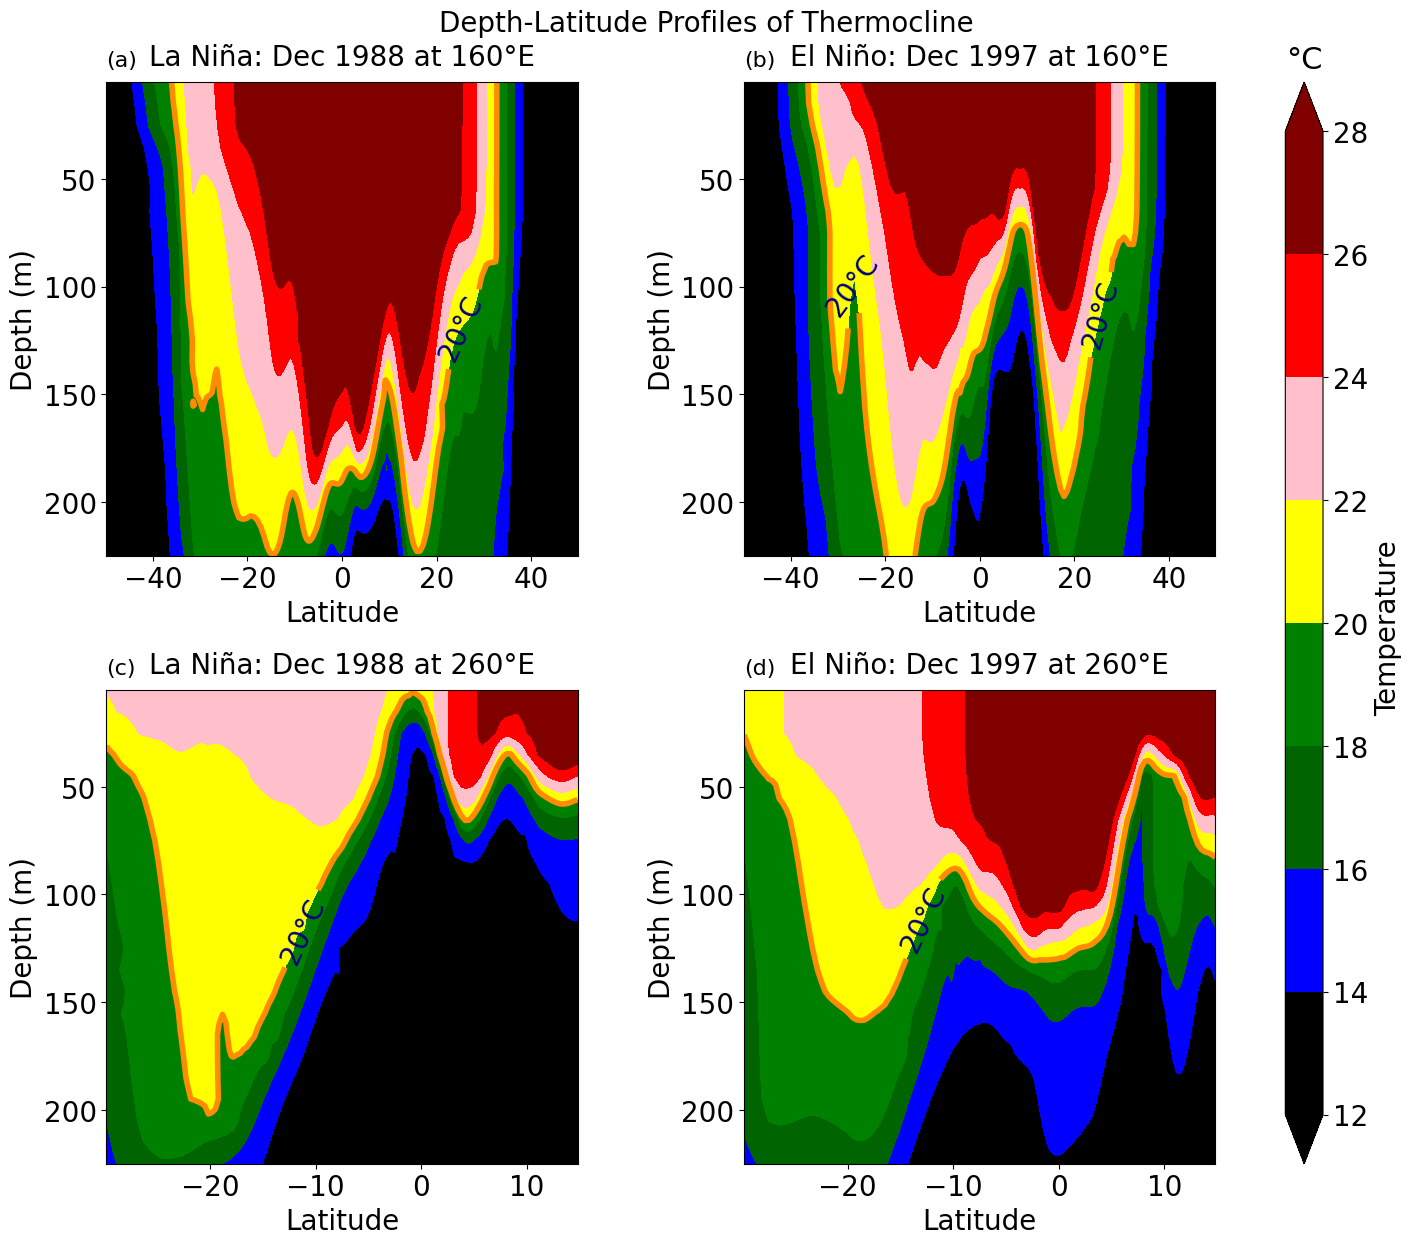

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator
import xarray as xr

def plot_depth_lat_ax(
    ax,
    file_path: str,
    target_lon: float,
    month: int = 12,
    iso_temp: float = 20.0,
    max_depth: float = 225,
    cmap_palette: list = None,
    levels: np.ndarray = None,
    lat_min: float = -50.0,
    lat_max: float =  50.0,
    panel_title: str = ""
):

    if cmap_palette is None:
        cmap_palette = [
            'black','blue','darkgreen','green',
            'white','yellow','pink','red','maroon'
        ]
    if levels is None:
        levels = np.arange(12, 30, 2)

    ds = xr.open_dataset(file_path)
    ds = ds.sel(
        lat   = slice(lat_min, lat_max),
        level = slice(0, max_depth)
    )
    lat   = ds['lat'].values          
    depth = ds['level'].values          
    temp  = ds['pottmp'].sel(
                time=ds['time'].dt.month == month
           ).mean(dim='time')       

    lon   = ds['lon'].values            
    i_lon = np.abs(lon - target_lon).argmin()
    lon_val = lon[i_lon]

    theta = temp.isel(lon=i_lon).values   

    cmap = ListedColormap(cmap_palette)
    cf = ax.contourf(
        lat, depth, theta,
        levels=levels,
        cmap=cmap,
        extend='both'
    )
    ax.invert_yaxis()            
    ax.yaxis.set_major_locator(MultipleLocator(50))

    c_iso = ax.contour(
        lat, depth, theta,
        levels=[iso_temp],
        colors='darkorange',
        linewidths=4
    )
    ax.clabel(
        c_iso,
        fmt=f"{iso_temp:.0f}°C",
        inline=True,
        fontsize=20,
        colors='navy'
    )

    ax.set_title(panel_title, fontsize=20, pad=12)
    ax.set_xlabel("Latitude", fontsize=20)
    ax.set_ylabel("Depth (m)",       fontsize=20)
    ax.tick_params(axis='both', labelsize=20)

    return cf

fig = plt.figure(constrained_layout=True, figsize=(14, 12))
gs  = fig.add_gridspec(2, 3, width_ratios=[1,1,0.08], wspace=0.15)

ax_tl = fig.add_subplot(gs[0, 0]) 
ax_tr = fig.add_subplot(gs[0, 1]) 
ax_bl = fig.add_subplot(gs[1, 0]) 
ax_br = fig.add_subplot(gs[1, 1])   
ax_tl.text(
    0, 1.025, '(a)',
    transform=ax_tl.transAxes,
    fontsize=16, va='bottom', ha='left'
)
ax_tr.text(
    0, 1.025, '(b)',
    transform=ax_tr.transAxes,
    fontsize=16, va='bottom', ha='left'
)
ax_bl.text(
    0, 1.025, '(c)',
    transform=ax_bl.transAxes,
    fontsize=16, va='bottom', ha='left'
)
ax_br.text(
    0, 1.025, '(d)',
    transform=ax_br.transAxes,
    fontsize=16, va='bottom', ha='left'
)

cf_tl = plot_depth_lat_ax(
    ax         = ax_tl,
    file_path  = 'pottmp/pottmp_1988_C.nc',
    target_lon = 160.0,
    month      = 12,
    iso_temp   = 20.0,
    max_depth  = 225,
    cmap_palette = ['black','blue','darkgreen','green',
                    'white','yellow','pink','red','maroon'],
    levels       = np.arange(12, 30, 2),
    lat_min      = -50.0,
    lat_max      =  50.0,
    panel_title  = "La Niña: Dec 1988 at 160°E"
)

cf_tr = plot_depth_lat_ax(
    ax         = ax_tr,
    file_path  = 'pottmp/pottmp_1997_C.nc',
    target_lon = 160.0,
    month      = 12,
    iso_temp   = 20.0,
    max_depth  = 225,
    cmap_palette = ['black','blue','darkgreen','green',
                    'white','yellow','pink','red','maroon'],
    levels       = np.arange(12, 30, 2),
    lat_min      = -50.0,
    lat_max      =  50.0,
    panel_title  = "El Niño: Dec 1997 at 160°E"
)

cf_bl = plot_depth_lat_ax(
    ax         = ax_bl,
    file_path  = 'pottmp/pottmp_1988_C.nc',
    target_lon = 260.0,
    month      = 12,
    iso_temp   = 20.0,
    max_depth  = 225,
    cmap_palette = ['black','blue','darkgreen','green',
                    'white','yellow','pink','red','maroon'],
    levels       = np.arange(12, 30, 2),
    lat_min      = -30.0,
    lat_max      =  15.0,
    panel_title  = "La Niña: Dec 1988 at 260°E"
)

cf_br = plot_depth_lat_ax(
    ax         = ax_br,
    file_path  = 'pottmp/pottmp_1997_C.nc',
    target_lon = 260.0,
    month      = 12,
    iso_temp   = 20.0,
    max_depth  = 225,
    cmap_palette = ['black','blue','darkgreen','green',
                    'white','yellow','pink','red','maroon'],
    levels       = np.arange(12, 30, 2),
    lat_min      = -30.0,
    lat_max      =  15.0,
    panel_title  = "El Niño: Dec 1997 at 260°E"
)

cax = fig.add_subplot(gs[:, 2])  
cbar = fig.colorbar(
    cf_tr,         
    cax=cax,
    ticks=np.arange(12, 30, 2),
    extend='both'
)
cbar.set_label('Temperature ', fontsize=20)
cbar.ax.set_title('°C', fontsize=22, pad=10)
cbar.ax.tick_params(labelsize=20)

plt.suptitle("Depth-Latitude Profiles of Thermocline", fontsize=20, y=1.025)
plt.savefig('thermoclinefigures/Figure1.png', 
            dpi=300,                
            bbox_inches='tight')
plt.show()


# Figure 2a/2b

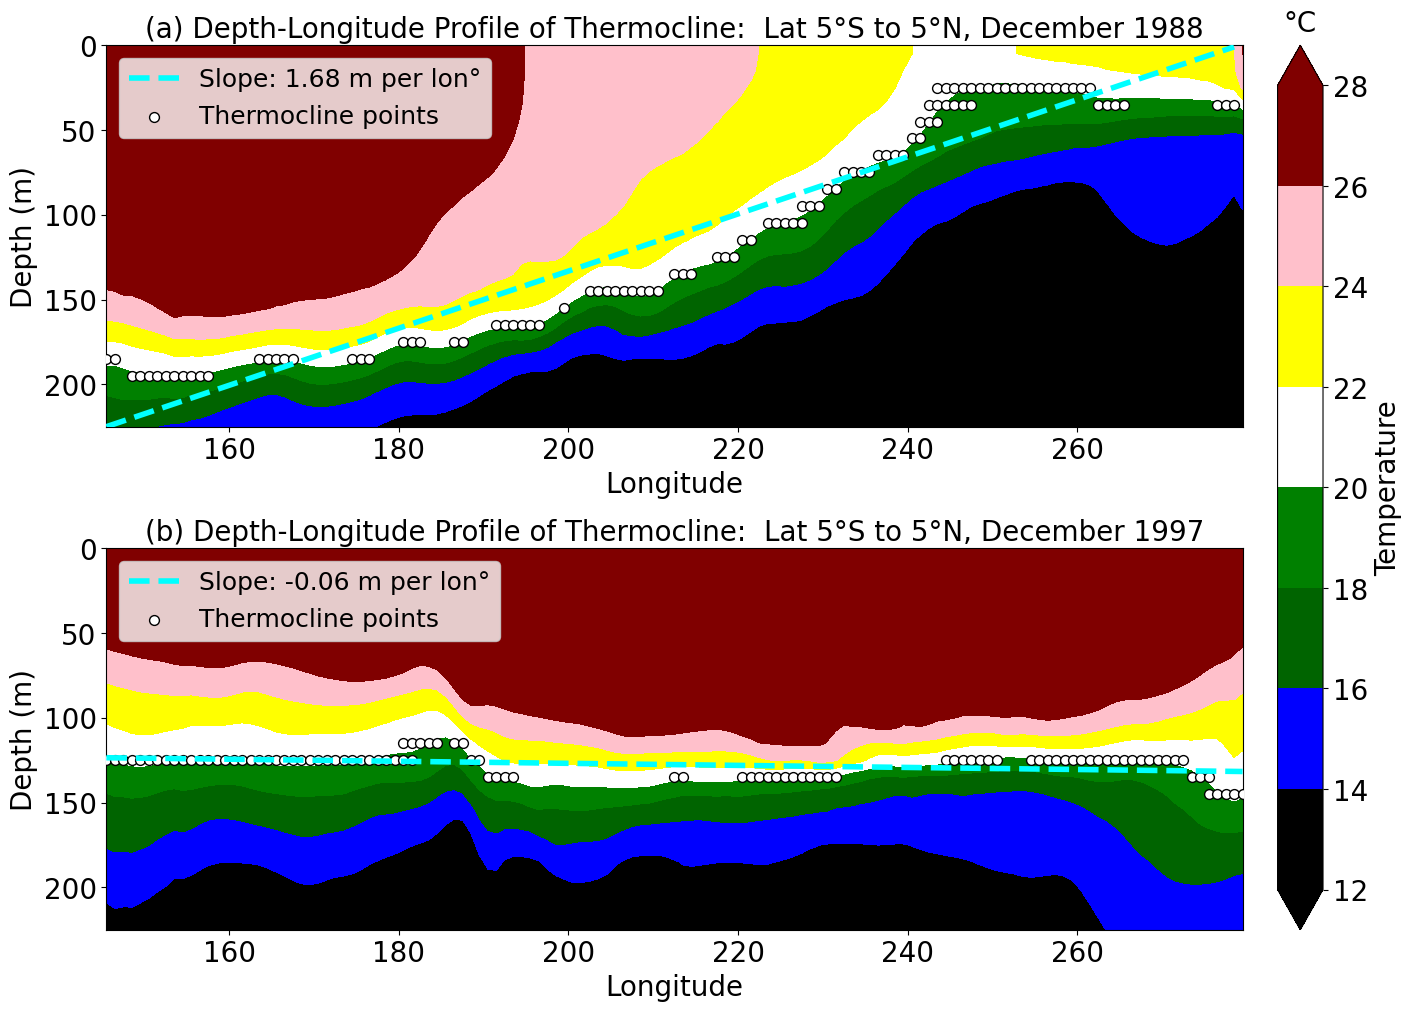

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.stats import linregress
import xarray as xr

LEVELS = np.arange(12, 30, 2)
CMAP   = ListedColormap(['black','blue','darkgreen','green',
                         'white','yellow','pink','red','maroon'])
NORM   = BoundaryNorm(LEVELS, ncolors=CMAP.N, clip=False)

def plot_lon_depth_ax(
    ax,
    file_path: str,
    month_of_interest: int,
    lat_start: float,
    lat_end: float,
    lon_start: float,
    lon_end: float,
    target_temp: float = 20.0,
    tolerance: float = 0.5,
    panel_title: str = "",
):
    month_names = [
        'January','February','March','April','May','June',
        'July','August','September','October','November','December'
    ]

    ds = xr.open_dataset(file_path)
    temp = ds['pottmp']

    temp_subset = (
        temp
        .sel(lat=slice(lat_start, lat_end),
             lon=slice(lon_start, lon_end),
             level=slice(0, 225))
        .sel(time=ds['time'].dt.month == month_of_interest)
        .mean(dim=['time', 'lat'])
    )

    surf_da     = temp_subset.isel(level=0).expand_dims(level=[0.0])
    temp_padded = xr.concat([surf_da, temp_subset], dim='level')

    lon_depth_pairs = []
    for i in range(temp_padded.sizes['lon']):
        profile     = temp_padded.isel(lon=i).values
        current_lon = float(temp_padded['lon'][i].values)
        mask = ((profile >= target_temp - tolerance) &
                (profile <= target_temp + tolerance))
        if mask.any():
            depths = temp_padded['level'].values[mask]
            for d in depths:
                lon_depth_pairs.append((current_lon, d))
    lon_depth_pairs = np.array(lon_depth_pairs)
    if lon_depth_pairs.size == 0:
        raise ValueError("No points found within specified temperature range.")

    valid_lons   = lon_depth_pairs[:, 0]
    valid_depths = lon_depth_pairs[:, 1]
    slope, intercept, *_ = linregress(valid_lons, valid_depths)
    idx = np.argsort(valid_lons)
    fitted_depths = slope * valid_lons[idx] + intercept

    cf = ax.contourf(
        temp_padded['lon'],
        temp_padded['level'],
        temp_padded,
        cmap=CMAP,
        norm=NORM,
        levels=LEVELS,
        extend='both'
    )
    ax.invert_yaxis()

    ax.plot(valid_lons[idx], fitted_depths, color="cyan", lw=4, ls='dashed',
            zorder=6, label=f"Slope: {-slope:.2f} m per lon°")
    ax.scatter(valid_lons, valid_depths, color='white', edgecolor='black',
               s=50, zorder=5, label="Thermocline points")

    year = int(ds['time.year'].values.max())
    ax.set_title(panel_title or
                 f"{month_names[month_of_interest-1]} {year}",
                 fontsize=20)
    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Depth (m)", fontsize=20)
    ax.tick_params(axis='both', labelsize=20)
    ax.legend(loc='upper left', fontsize=18)

    return cf

fig = plt.figure(constrained_layout=True, figsize=(14, 10))
gs  = fig.add_gridspec(2, 2, width_ratios=[1, 0.04], wspace=0.05)

ax_top = fig.add_subplot(gs[0, 0])
ax_bot = fig.add_subplot(gs[1, 0])

cf_top = plot_lon_depth_ax(
    ax=ax_top,
    file_path='pottmp/pottmp_1988_C.nc',
    month_of_interest=12,
    lat_start=-5, lat_end=5,
    lon_start=145, lon_end=280,
    target_temp=20.0, tolerance=0.5,
    panel_title=f"(a) Depth-Longitude Profile of Thermocline:  Lat 5°S to 5°N, December 1988"
)

cf_bot = plot_lon_depth_ax(
    ax=ax_bot,
    file_path='pottmp/pottmp_1997_C.nc',
    month_of_interest=12,
    lat_start=-5, lat_end=5,
    lon_start=145, lon_end=280,
    target_temp=20.0, tolerance=0.5,
    panel_title=f"(b) Depth-Longitude Profile of Thermocline:  Lat 5°S to 5°N, December 1997"
)

cax = fig.add_subplot(gs[:, 1])
sm  = mpl.cm.ScalarMappable(norm=NORM, cmap=CMAP)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, ticks=LEVELS, extend='both')
cbar.set_label('Temperature', fontsize=20)
cbar.ax.set_title('°C', fontsize=20, pad=10)
cbar.ax.tick_params(labelsize=20)

plt.savefig('thermoclinefigures/Figure2ab.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3/4

0 2 134
shapes: (105, 135) (25, 135) (25, 105)
(25, 135)


C:\Users\maxhi\AppData\Local\Temp\ipykernel_27444\2203065211.py:234: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


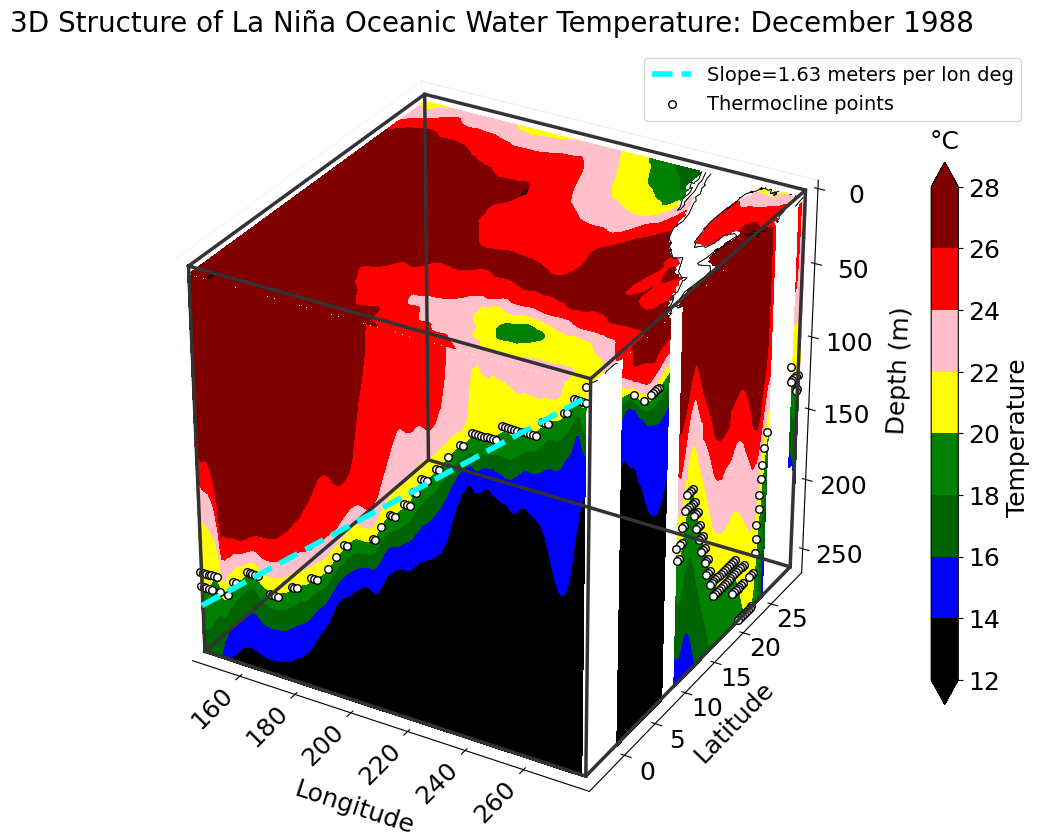

In [8]:
cmap_palette       = ['black','blue','darkgreen','green',
                      'white','yellow','pink','red','maroon']
cmap=ListedColormap(cmap_palette)

ds   = xr.open_dataset('pottmp/pottmp_1988_C.nc')
ds_sel = ds.sel(
    level= slice(0, 300),
    lat  = slice(-5.0, 30.0),
    lon  = slice(145.0, 280.0)
)

temp = (
    ds_sel['pottmp']
      .sel(time= ds_sel['time'].dt.month == 12)
      .mean(dim='time')
)

depths = ds_sel['level'].values
lats   = ds_sel['lat'].values
lons   = ds_sel['lon'].values
X, Y, Z = np.meshgrid(lons, lats, -depths)

iz   = 0  
ilat = np.abs(lats - (-4.167)).argmin()
ilon = np.abs(lons - 280.0).argmin()
print(iz,ilat,ilon)
surface   = temp.isel(level=iz     ).values   
lat_depth = temp.isel(lat  =ilat  ).values   
lon_depth = temp.isel(lon  =ilon  ).values  

print("shapes:", surface.shape, lat_depth.shape, lon_depth.shape)

fig = plt.figure(figsize=(14, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.grid(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
vmin, vmax    = temp.min(), temp.max()
levels = np.arange(12, 30, 2)

cs=ax.contourf(
    X[:,:,0], Y[:,:,0], surface,
    zdir='z',                
    offset=-depths[iz],      
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)
m = Basemap(
    projection='cyl',
    llcrnrlon=lons.min(), urcrnrlon=lons.max(),
    llcrnrlat=lats.min(), urcrnrlat=lats.max()
)

coast = m.drawcoastlines(linewidth=0.5)
ax.add_collection3d(
    coast, 
    zs=-depths[iz],   
    zdir='z'
)

ax.contourf(
    X[0,:,:], lat_depth.T, Z[0,:,:],
    zdir='y',              
    offset=-5,     
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

target_temp = 20.0
tol         = 0.5

profile2d = lat_depth     
print(profile2d.shape)
pairs = []
for j, lonval in enumerate(lons):
    prof = profile2d[:, j]
    mask = (prof >= target_temp - tol) & (prof <= target_temp + tol)
    for d in depths[mask]:
        pairs.append((lonval, d))

if pairs:
    arr = np.array(pairs)
    xs, ys = arr[:,0], arr[:,1]
    slope, intercept, _, _, _ = linregress(xs, ys)
    fit_z = slope * xs + intercept
    order = np.argsort(xs)

    ax.plot(
        xs[order],    
        -fit_z[order], 
        zs=-5,         
        zdir='y',   
        color='cyan',
        lw=4, ls='dashed',
        label=f"Slope={-slope:.2f} meters per lon deg",
        zorder=200
    )

    ax.scatter(
        xs, -ys,
        zs=-5, zdir='y',
        color='white', edgecolor='black',
        s=30, zorder=101,
        label="Thermocline points",
        depthshade=False
    )

    ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1), fontsize=14)


Y2d3, Z2d3 = np.meshgrid(lats, -depths)   
ax.contourf(
    lon_depth.T, Y[:,-1,:], Z[:,-1,:],
    zdir='x',               
    offset=280,   
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

target_temp = 20.0
tol = 0.5

lat_hits   = []
depth_hits = []

for j, latv in enumerate(lats):
    prof = lon_depth[:, j]  
    mask = (prof >= target_temp - tol) & (prof <= target_temp + tol)
    for d in depths[mask]:
        lat_hits.append(latv)
        depth_hits.append(d)

if lat_hits:
    xs = np.array(lat_hits)   
    zs = -np.array(depth_hits) 

    ax.scatter(
        np.full_like(xs, lons[ilon]),  
        xs,                             
        zs,                          
        color='white', edgecolor='black',
        s=30, depthshade=False,
        label="20 °C points (lon=280°E)",
        zorder=200
    )

xmin, xmax = lons.min(), lons.max()
ymin, ymax = lats.min(), lats.max()
zmin, zmax = -depths.max(),   0      

edges_kw = dict(color='0.2', linewidth=2.5, zorder=100)

ax.plot(
    [xmin, xmax, xmax, xmin, xmin],
    [ymin, ymin, ymax, ymax, ymin],
    [zmin]*5,
    **edges_kw
)

ax.plot(
    [xmin, xmax, xmax, xmin, xmin],
    [ymin, ymin, ymax, ymax, ymin],
    [zmax]*5,
    **edges_kw
)

for x in (xmin, xmax):
    for y in (ymin, ymax):
        ax.plot(
            [x, x],
            [y, y],
            [zmin, zmax],
            **edges_kw
        )

lon_ticks = np.arange(160, 281, 20)  
lat_ticks = np.arange(-5, 31, 5)
depth_ticks = np.arange(0, depths.max()+1, 50).astype('int64')
                                                      
ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_zticks(-depth_ticks)

ax.set_xticklabels([f"{t:.0f}" for t in lon_ticks], rotation=45, ha='right')
ax.set_yticklabels([f"{t:.0f}" for t in lat_ticks],va='bottom',fontsize=12)
ax.set_zticklabels(depth_ticks)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='z',pad=10,labelsize=18)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=8)

ax.set_xlabel('Longitude',fontsize = 18, labelpad=18)
ax.set_ylabel('Latitude',fontsize = 18)
ax.set_zlabel('Depth (m)',fontsize = 18, labelpad=22)

ax.set_xlim(lons.min(), lons.max())
ax.set_ylim(lats.min(), lats.max())
ax.set_zlim(-depths.max(), 0)

dx = float(lons.max() - lons.min())
dy = float(lats.max() - lats.min())
dz = float(depths.max() - depths.min())

ax.set_box_aspect((1, 1, 1))

ax.view_init(elev=30, azim=-60)

m = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax))
m.set_array([])
cbar = fig.colorbar(
    cs,
    ax=ax,
    ticks=levels,
    extend='both',
    fraction=0.025,
    pad=0.05
)
cbar.set_label('Temperature ', fontsize=18)
cbar.ax.set_title('°C', fontsize=18, pad=10)
cbar.ax.tick_params(labelsize=18)
ax.set_title(
    f"3D Structure of La Niña Oceanic Water Temperature: December 1988",
    fontsize=20, 
    pad=12
)
plt.tight_layout()
plt.savefig('thermoclinefigures/Figure3.png', 
            dpi=300,              
            bbox_inches='tight')  
plt.show()


0 2 134
shapes: (105, 135) (25, 135) (25, 105)
(25, 135)


C:\Users\maxhi\AppData\Local\Temp\ipykernel_27444\2117434913.py:234: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


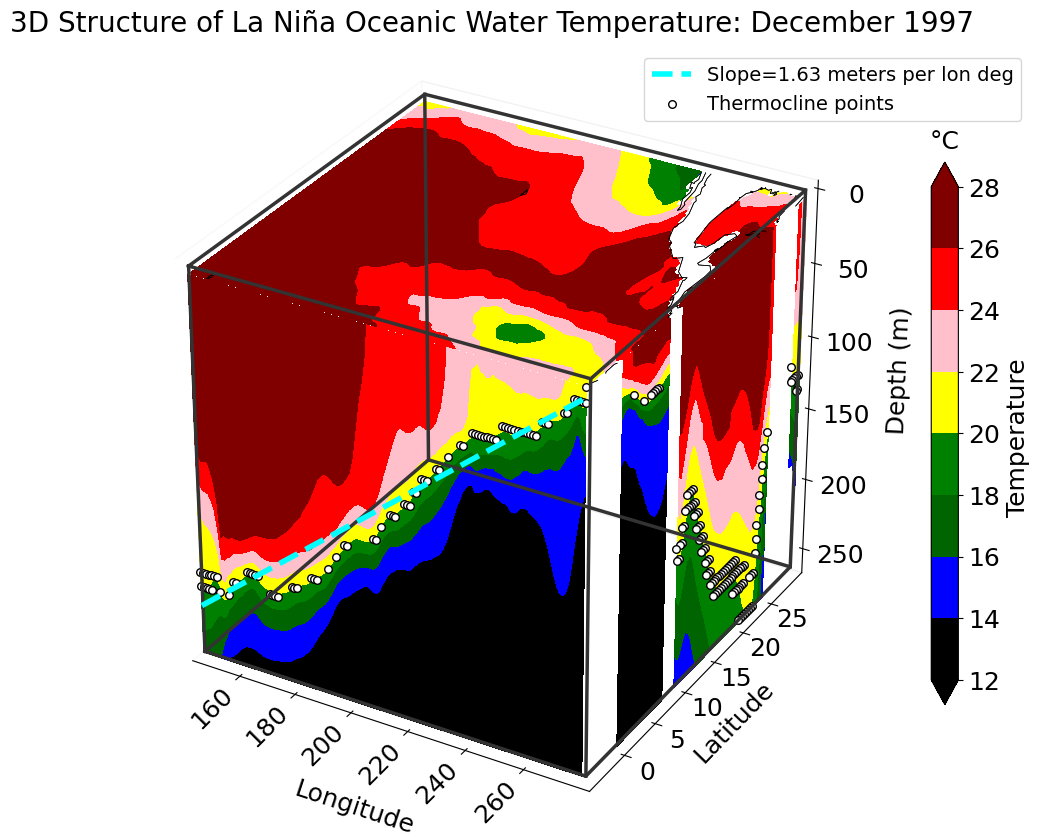

In [9]:
cmap_palette       = ['black','blue','darkgreen','green',
                      'white','yellow','pink','red','maroon']
cmap=ListedColormap(cmap_palette)

ds   = xr.open_dataset('pottmp/pottmp_1988_C.nc')
ds_sel = ds.sel(
    level= slice(0, 300),
    lat  = slice(-5.0, 30.0),
    lon  = slice(145.0, 280.0)
)

temp = (
    ds_sel['pottmp']
      .sel(time= ds_sel['time'].dt.month == 12)
      .mean(dim='time')
)

depths = ds_sel['level'].values
lats   = ds_sel['lat'].values
lons   = ds_sel['lon'].values
X, Y, Z = np.meshgrid(lons, lats, -depths)

iz   = 0  
ilat = np.abs(lats - (-4.167)).argmin()
ilon = np.abs(lons - 280.0).argmin()
print(iz,ilat,ilon)
surface   = temp.isel(level=iz     ).values   
lat_depth = temp.isel(lat  =ilat  ).values   
lon_depth = temp.isel(lon  =ilon  ).values  

print("shapes:", surface.shape, lat_depth.shape, lon_depth.shape)

fig = plt.figure(figsize=(14, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.grid(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
vmin, vmax    = temp.min(), temp.max()
levels = np.arange(12, 30, 2)

cs=ax.contourf(
    X[:,:,0], Y[:,:,0], surface,
    zdir='z',                
    offset=-depths[iz],      
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)
m = Basemap(
    projection='cyl',
    llcrnrlon=lons.min(), urcrnrlon=lons.max(),
    llcrnrlat=lats.min(), urcrnrlat=lats.max()
)

coast = m.drawcoastlines(linewidth=0.5)
ax.add_collection3d(
    coast, 
    zs=-depths[iz],   
    zdir='z'
)

ax.contourf(
    X[0,:,:], lat_depth.T, Z[0,:,:],
    zdir='y',              
    offset=-5,     
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

target_temp = 20.0
tol         = 0.5

profile2d = lat_depth     
print(profile2d.shape)
pairs = []
for j, lonval in enumerate(lons):
    prof = profile2d[:, j]
    mask = (prof >= target_temp - tol) & (prof <= target_temp + tol)
    for d in depths[mask]:
        pairs.append((lonval, d))

if pairs:
    arr = np.array(pairs)
    xs, ys = arr[:,0], arr[:,1]
    slope, intercept, _, _, _ = linregress(xs, ys)
    fit_z = slope * xs + intercept
    order = np.argsort(xs)

    ax.plot(
        xs[order],    
        -fit_z[order], 
        zs=-5,         
        zdir='y',   
        color='cyan',
        lw=4, ls='dashed',
        label=f"Slope={-slope:.2f} meters per lon deg",
        zorder=200
    )

    ax.scatter(
        xs, -ys,
        zs=-5, zdir='y',
        color='white', edgecolor='black',
        s=30, zorder=101,
        label="Thermocline points",
        depthshade=False
    )

    ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1), fontsize=14)


Y2d3, Z2d3 = np.meshgrid(lats, -depths)   
ax.contourf(
    lon_depth.T, Y[:,-1,:], Z[:,-1,:],
    zdir='x',               
    offset=280,   
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

target_temp = 20.0
tol = 0.5

lat_hits   = []
depth_hits = []

for j, latv in enumerate(lats):
    prof = lon_depth[:, j]  
    mask = (prof >= target_temp - tol) & (prof <= target_temp + tol)
    for d in depths[mask]:
        lat_hits.append(latv)
        depth_hits.append(d)

if lat_hits:
    xs = np.array(lat_hits)   
    zs = -np.array(depth_hits) 

    ax.scatter(
        np.full_like(xs, lons[ilon]),  
        xs,                             
        zs,                          
        color='white', edgecolor='black',
        s=30, depthshade=False,
        label="20 °C points (lon=280°E)",
        zorder=200
    )

xmin, xmax = lons.min(), lons.max()
ymin, ymax = lats.min(), lats.max()
zmin, zmax = -depths.max(),   0      

edges_kw = dict(color='0.2', linewidth=2.5, zorder=100)

ax.plot(
    [xmin, xmax, xmax, xmin, xmin],
    [ymin, ymin, ymax, ymax, ymin],
    [zmin]*5,
    **edges_kw
)

ax.plot(
    [xmin, xmax, xmax, xmin, xmin],
    [ymin, ymin, ymax, ymax, ymin],
    [zmax]*5,
    **edges_kw
)

for x in (xmin, xmax):
    for y in (ymin, ymax):
        ax.plot(
            [x, x],
            [y, y],
            [zmin, zmax],
            **edges_kw
        )

lon_ticks = np.arange(160, 281, 20)  
lat_ticks = np.arange(-5, 31, 5)
depth_ticks = np.arange(0, depths.max()+1, 50).astype('int64')
                                                      
ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_zticks(-depth_ticks)

ax.set_xticklabels([f"{t:.0f}" for t in lon_ticks], rotation=45, ha='right')
ax.set_yticklabels([f"{t:.0f}" for t in lat_ticks],va='bottom',fontsize=12)
ax.set_zticklabels(depth_ticks)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='z',pad=10,labelsize=18)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=8)

ax.set_xlabel('Longitude',fontsize = 18, labelpad=18)
ax.set_ylabel('Latitude',fontsize = 18)
ax.set_zlabel('Depth (m)',fontsize = 18, labelpad=22)

ax.set_xlim(lons.min(), lons.max())
ax.set_ylim(lats.min(), lats.max())
ax.set_zlim(-depths.max(), 0)

dx = float(lons.max() - lons.min())
dy = float(lats.max() - lats.min())
dz = float(depths.max() - depths.min())

ax.set_box_aspect((1, 1, 1))

ax.view_init(elev=30, azim=-60)

m = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax))
m.set_array([])
cbar = fig.colorbar(
    cs,
    ax=ax,
    ticks=levels,
    extend='both',
    fraction=0.025,
    pad=0.05
)
cbar.set_label('Temperature ', fontsize=18)
cbar.ax.set_title('°C', fontsize=18, pad=10)
cbar.ax.tick_params(labelsize=18)
ax.set_title(
    f"3D Structure of La Niña Oceanic Water Temperature: December 1997",
    fontsize=20, 
    pad=12
)
plt.tight_layout()
plt.savefig('thermoclinefigures/Figure4.png', 
            dpi=300,              
            bbox_inches='tight')  
plt.show()


# Figure 5

In [10]:
from ipywidgets import interact, IntRangeSlider
import matplotlib.pyplot as plt
import pandas as pd

def plot_continuous_time_series(year_range):
    start_year, end_year = year_range
    df_range = df_slopes[
        (df_slopes['Year'] >= start_year) &
        (df_slopes['Year'] <= end_year)
    ].copy()
    
    df_range['Date'] = pd.to_datetime(
        df_range['Year'].astype(str) + '-' +
        df_range['Month'].astype(str) + '-01'
    )
    df_range.sort_values('Date', inplace=True)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(
        df_range['Date'], 
        df_range['Slope'],
        color='darkorange', 
        linewidth=2.5,    
        marker='o',
        markerfacecolor='white',
        markeredgecolor='black',
        markeredgewidth=2
    )
    
    plt.title(
        f'Time Series of the Zonal Thermocline Slope (ZTS) from January {start_year} to December {end_year}',
        fontsize=16
    )
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Slope (meters per lon deg)', fontsize=16)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('thermoclinefigures/Figure5.png', 
            dpi=300,         
            bbox_inches='tight')
    plt.show()

year_range_slider = IntRangeSlider(
    value=[1996, 1998],
    min=1980,
    max=2020,
    step=1,
    description='Year Range:',
    continuous_update=False
)

interact(plot_continuous_time_series, year_range=year_range_slider)

interactive(children=(IntRangeSlider(value=(1996, 1998), continuous_update=False, description='Year Range:', m…

<function __main__.plot_continuous_time_series(year_range)>

# Figure 6

In [11]:
el_nino_years = {
    'Very Strong El Niño': [(1982, 1983), (1997, 1998), (2015, 2016)],
    'Strong El Niño': [(1987, 1988), (1991, 1992), (2023, 2024)],
    'Moderate El Niño': [(1986, 1987), (1994, 1995), (2002, 2003), (2009, 2010)],
    'Strong La Niña':[(1973,1974),(1975,1976),(1988,1989),(1998,1999),(1999,2000),(2007,2008),(2010,2011)],
    'Moderate La Niña':[(1995,1996),(2011,2012),(2020,2021)]
}

def get_el_nino_strength(year, month):
    for strength, pairs in el_nino_years.items():
        for start_year, end_year in pairs:
            if 1 <= month <= 6: 
                if year == end_year:
                    return strength
            elif 7 <= month <= 12:  
                if year == start_year:
                    return strength
    return None

df_slopes['El Nino Strength'] = df_slopes.apply(lambda row: get_el_nino_strength(row['Year'], row['Month']), axis=1)

df_slopes['Month Name'] = pd.to_datetime(df_slopes['Month'], format='%m').dt.strftime('%B')


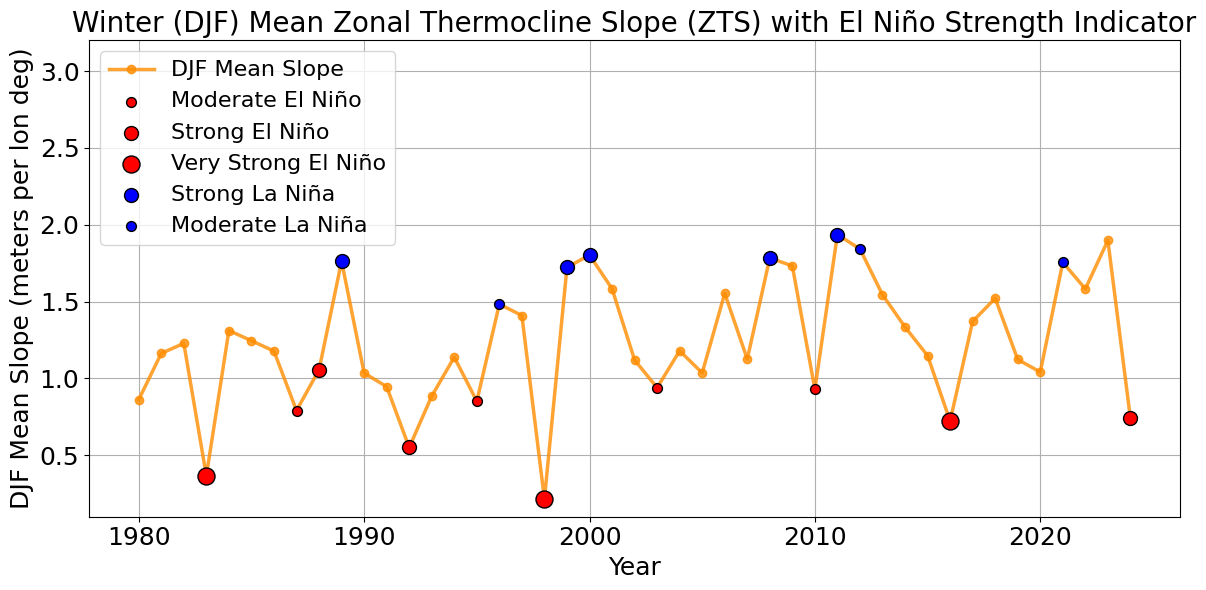

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_slopes['winter_year'] = df_slopes.apply(
    lambda row: row['Year'] + 1 if row['Month'] == 12 else row['Year'],
    axis=1
)
df_DJF = df_slopes[df_slopes['Month'].isin([12, 1, 2])]
df_DJF_avg = df_DJF.groupby('winter_year', as_index=False)['Slope'].mean()
df_DJF_avg['El Nino Strength'] = df_DJF_avg['winter_year'].apply(
    lambda y: get_el_nino_strength(y, 1)
)

plt.figure(figsize=(12, 6))

plt.plot(
    df_DJF_avg['winter_year'],
    df_DJF_avg['Slope'],
    color='darkorange',
    linewidth=2.5,
    marker='o',
    markersize=6,
    alpha=0.8,
    label='DJF Mean Slope'
)

for strength, size, color in zip(
    ['Moderate El Niño', 'Strong El Niño', 'Very Strong El Niño',
     'Strong La Niña', 'Moderate La Niña'],
    [50, 100, 150, 100, 50],
    ['red', 'red', 'red', 'blue', 'blue']
):
    df_strength = df_DJF_avg[df_DJF_avg['El Nino Strength'] == strength]
    plt.scatter(
        df_strength['winter_year'],
        df_strength['Slope'],
        label=strength,
        color=color,
        edgecolor='black',
        s=size,
        zorder=5
    )

plt.title(
    'Winter (DJF) Mean Zonal Thermocline Slope (ZTS) with El Niño Strength Indicator',
    fontsize=20
)
plt.xlabel('Year', fontsize=18)
plt.ylabel('DJF Mean Slope (meters per lon deg)', fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0.1, 3.2)
plt.legend(fontsize=16, loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.savefig('thermoclinefigures/Figure6.png', 
            dpi=300,              
            bbox_inches='tight')   
plt.show()

# Table 1 and Figure 8

In [13]:
path = 'oni.nc'
oni= xr.open_dataset(path)
oni

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 901)
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2025-01-01
Data variables:
    value    (time) float32 4kB ...

In [14]:
oni_all_df = oni.to_dataframe().reset_index()
oni_all_df['Year'] = oni_all_df['time'].dt.year
oni_all_df['Month'] = oni_all_df['time'].dt.month

merged_all = pd.merge(df_slopes, oni_all_df, on=['Year', 'Month'], how='inner')

merged_all = merged_all.dropna(subset=['Slope', 'value'])
merged_all['time'] = pd.to_datetime(
    merged_all[['Year', 'Month']].assign(day=15)
)

if len(merged_all) < 2:
    r, p = np.nan, np.nan
else:
    r, p = pearsonr(merged_all['Slope'], merged_all['value'])

print("Overall Pearson correlation:")
print("Pearson r:", r)
print("p-value:", p)
merged_all
output_path = 'merged_all_1980_2023.csv'
merged_all.to_csv(output_path, index=False)

Overall Pearson correlation:
Pearson r: -0.8628097353982449
p-value: 5.961908554861662e-158


In [15]:
nino12=pd.read_csv('nino12.long.anom.csv')
nino12.columns

Index(['Date', '   NINA12  missing value -99.99 https://psl.noaa.gov/data/timeseries/month/'], dtype='object')

In [16]:
from scipy.stats import linregress

nino12 = pd.read_csv('nino12.long.anom.csv')

nino12.columns = ['Date', 'NINO12']
nino12['Date']  = pd.to_datetime(nino12['Date'])
nino12['Year']  = nino12['Date'].dt.year
nino12['Month'] = nino12['Date'].dt.month

merged_nino12 = (
    pd.merge(df_slopes, nino12, on=['Year','Month'], how='inner')
      .dropna(subset=['Slope','NINO12'])
)
merged_nino12

,Year,Month,Slope,Intercept,Date_x,El Nino Strength,Month Name,winter_year,Date_y,NINO12
0,1980,1,0.777796,399.183842,1980-01-01,None,January,1980,1980-01-01,-0.10
1,1980,2,0.945578,457.069906,1980-02-01,None,February,1980,1980-02-01,-0.25
2,1980,3,1.267728,570.064919,1980-03-01,None,March,1980,1980-03-01,0.02
3,1980,4,1.452884,635.060524,1980-04-01,None,April,1980,1980-04-01,-0.00
4,1980,5,1.209258,555.571200,1980-05-01,None,May,1980,1980-05-01,0.25
...,...,...,...,...,...,...,...,...,...,...
523,2023,8,1.148335,530.237147,2023-08-01,Strong El Niño,August,2023,2023-08-01,2.55
524,2023,9,1.051140,497.593774,2023-09-01,Strong El Niño,September,2023,2023-09-01,2.04
525,2023,10,1.123590,526.913623,2023-10-01,Strong El Niño,October,2023,2023-10-01,1.80
526,2023,11,1.054057,501.472527,2023-11-01,Strong El Niño,November,2023,2023-11-01,1.94


In [17]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.stats import pearsonr

correlation_results = []

for month in range(1, 13):
    oni_month = oni.sel(time=oni['time'].dt.month == month)
    oni_month_df = oni_month.to_dataframe().reset_index()

    oni_month_df['Year'] = oni_month_df['time'].dt.year
    oni_month_df['Month'] = oni_month_df['time'].dt.month

    month_slopes = df_slopes[df_slopes['Month'] == month]

    merged_data = pd.merge(month_slopes, oni_month_df, on=['Year', 'Month'], how='inner')
    
    merged_data = merged_data.dropna(subset=['Slope', 'value'])

    if len(merged_data) < 2:
        r, p = np.nan, np.nan
    else:
        r, p = pearsonr(merged_data['Slope'], merged_data['value'])
    
    correlation_results.append({
        'Month': month,
        'Pearson_r': r,
        'p_value': p,
        'n_points': len(merged_data)
    })

df_correlations = pd.DataFrame(correlation_results)
df_correlations['Pearson_r'] = df_correlations['Pearson_r'].round(2)

oni_df = oni.to_dataframe().reset_index()
oni_df['Year'] = oni_df['time'].dt.year
oni_df['Month'] = oni_df['time'].dt.month

merged_overall = pd.merge(df_slopes, oni_df, on=['Year', 'Month'], how='inner')
merged_overall = merged_overall.dropna(subset=['Slope', 'value'])

if len(merged_overall) < 2:
    r_overall, p_overall = np.nan, np.nan
else:
    r_overall, p_overall = pearsonr(merged_overall['Slope'], merged_overall['value'])

overall_corr = pd.DataFrame([{
    'Month': 'Overall',
    'Pearson_r': round(r_overall, 2),
    'p_value': p_overall,
    'n_points': len(merged_overall)
}])

combined_results = pd.concat([df_correlations, overall_corr], ignore_index=True)
combined_results['p_value'] = combined_results['p_value'].apply(lambda x: f'{x:.2e}')
combined_results

,Month,Pearson_r,p_value,n_points
0,1,-0.88,2.57e-15,44
1,2,-0.88,7.67e-15,44
2,3,-0.89,1.38e-15,44
3,4,-0.84,1.53e-12,44
4,5,-0.83,4.43e-12,44
5,6,-0.84,1.37e-12,44
6,7,-0.79,1.45e-10,44
7,8,-0.85,2.82e-13,44
8,9,-0.87,3.26e-14,44
9,10,-0.89,2.74e-16,44


In [18]:
combined_results_indexed = combined_results.set_index('Month')

combined_results_transposed = combined_results_indexed.T
combined_results_transposed

Month,1,2,3,4,5,6,7,8,9,10,11,12,Overall
Pearson_r,-0.88,-0.88,-0.89,-0.84,-0.83,-0.84,-0.79,-0.85,-0.87,-0.89,-0.92,-0.91,-0.86
p_value,2.57e-15,7.67e-15,1.38e-15,1.53e-12,4.43e-12,1.37e-12,1.45e-10,2.82e-13,3.26e-14,2.74e-16,9.90e-19,6.40e-18,5.96e-158
n_points,44,44,44,44,44,44,44,44,44,44,44,44,528


In [19]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

results = []

for month in range(1, 13):
    oni_month = oni.sel(time=oni['time'].dt.month == month).to_dataframe().reset_index()
    oni_month['Year']  = oni_month['time'].dt.year
    oni_month['Month'] = oni_month['time'].dt.month

    slopes_m = df_slopes[df_slopes['Month'] == month]
    merged_oni = pd.merge(slopes_m, oni_month, on=['Year','Month'], how='inner')\
                   .dropna(subset=['Slope','value'])
    if len(merged_oni) >= 2:
        r_oni, _ = pearsonr(merged_oni['Slope'], merged_oni['value'])
    else:
        r_oni = np.nan

    n12_month = nino12[nino12['Month'] == month]
    merged_n12 = pd.merge(slopes_m, n12_month, on=['Year','Month'], how='inner')\
                    .dropna(subset=['Slope','NINO12'])
    if len(merged_n12) >= 2:
        _, p_n12 = spearmanr(merged_n12['Slope'], merged_n12['NINO12'])
    else:
        p_n12 = np.nan

    results.append({
        'Month': month,
        'ONI_pearson_r': round(r_oni, 2),
        'NINO1+2_spearman_p': p_n12
    })

df_corr = pd.DataFrame(results)
df_corr

,Month,ONI_pearson_r,NINO1+2_spearman_p
0,1,-0.88,1.188720e-06
1,2,-0.88,3.999892e-02
2,3,-0.89,5.681051e-02
3,4,-0.84,1.324754e-04
4,5,-0.83,7.156583e-10
5,6,-0.84,6.293631e-07
6,7,-0.79,1.358200e-07
7,8,-0.85,1.589683e-05
8,9,-0.87,8.408658e-08
9,10,-0.89,6.284521e-11


In [20]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

results = []

for month in range(1, 13):
    slopes_m = df_slopes[df_slopes['Month'] == month]

    oni_month = (
        oni.sel(time=oni['time'].dt.month == month)
           .to_dataframe()
           .reset_index()
    )
    oni_month['Year']  = oni_month['time'].dt.year
    oni_month['Month'] = oni_month['time'].dt.month
    merged_oni = (
        pd.merge(slopes_m, oni_month, on=['Year','Month'], how='inner')
          .dropna(subset=['Slope','value'])
    )
    r_oni = pearsonr(merged_oni['Slope'], merged_oni['value'])[0] \
            if len(merged_oni) >= 2 else np.nan

    n12_month = nino12[nino12['Month'] == month]
    merged_n12 = (
        pd.merge(slopes_m, n12_month, on=['Year','Month'], how='inner')
          .dropna(subset=['Slope','NINO12'])
    )
    r_n12 = pearsonr(merged_n12['Slope'], merged_n12['NINO12'])[0] \
            if len(merged_n12) >= 2 else np.nan

    results.append({
        'Month': month,
        'ONI_pearson_r': round(r_oni, 2),
        'NINO1+2_pearson_r': round(r_n12, 2)
    })

oni_df = oni.to_dataframe().reset_index()
oni_df['Year']  = oni_df['time'].dt.year
oni_df['Month'] = oni_df['time'].dt.month
merged_all_oni = (
    pd.merge(df_slopes, oni_df, on=['Year','Month'], how='inner')
      .dropna(subset=['Slope','value'])
)
r_all_oni = pearsonr(merged_all_oni['Slope'], merged_all_oni['value'])[0]

merged_all_n12 = (
    pd.merge(df_slopes, nino12, on=['Year','Month'], how='inner')
      .dropna(subset=['Slope','NINO12'])
)
r_all_n12 = pearsonr(merged_all_n12['Slope'], merged_all_n12['NINO12'])[0]

results.append({
    'Month': 'Overall',
    'ONI_pearson_r': round(r_all_oni, 2),
    'NINO1+2_pearson_r': round(r_all_n12, 2)
})

df_corr = pd.DataFrame(results)

df_corr.to_csv(
    'monthly_plus_overall_slope_oni_nino12_pearson.csv',
    index=False
)
print(df_corr)


      Month  ONI_pearson_r  NINO1+2_pearson_r
0         1          -0.88              -0.67
1         2          -0.88              -0.48
2         3          -0.89              -0.46
3         4          -0.84              -0.65
4         5          -0.83              -0.81
5         6          -0.84              -0.71
6         7          -0.79              -0.75
7         8          -0.85              -0.71
8         9          -0.87              -0.77
9        10          -0.89              -0.84
10       11          -0.92              -0.86
11       12          -0.91              -0.84
12  Overall          -0.86              -0.68


In [21]:
df_corr_indexed = df_corr.set_index('Month')

df_corr_transposed = df_corr_indexed.T
df_corr_transposed

Month,1,2,3,4,5,6,7,8,9,10,11,12,Overall
ONI_pearson_r,-0.88,-0.88,-0.89,-0.84,-0.83,-0.84,-0.79,-0.85,-0.87,-0.89,-0.92,-0.91,-0.86
NINO1+2_pearson_r,-0.67,-0.48,-0.46,-0.65,-0.81,-0.71,-0.75,-0.71,-0.77,-0.84,-0.86,-0.84,-0.68


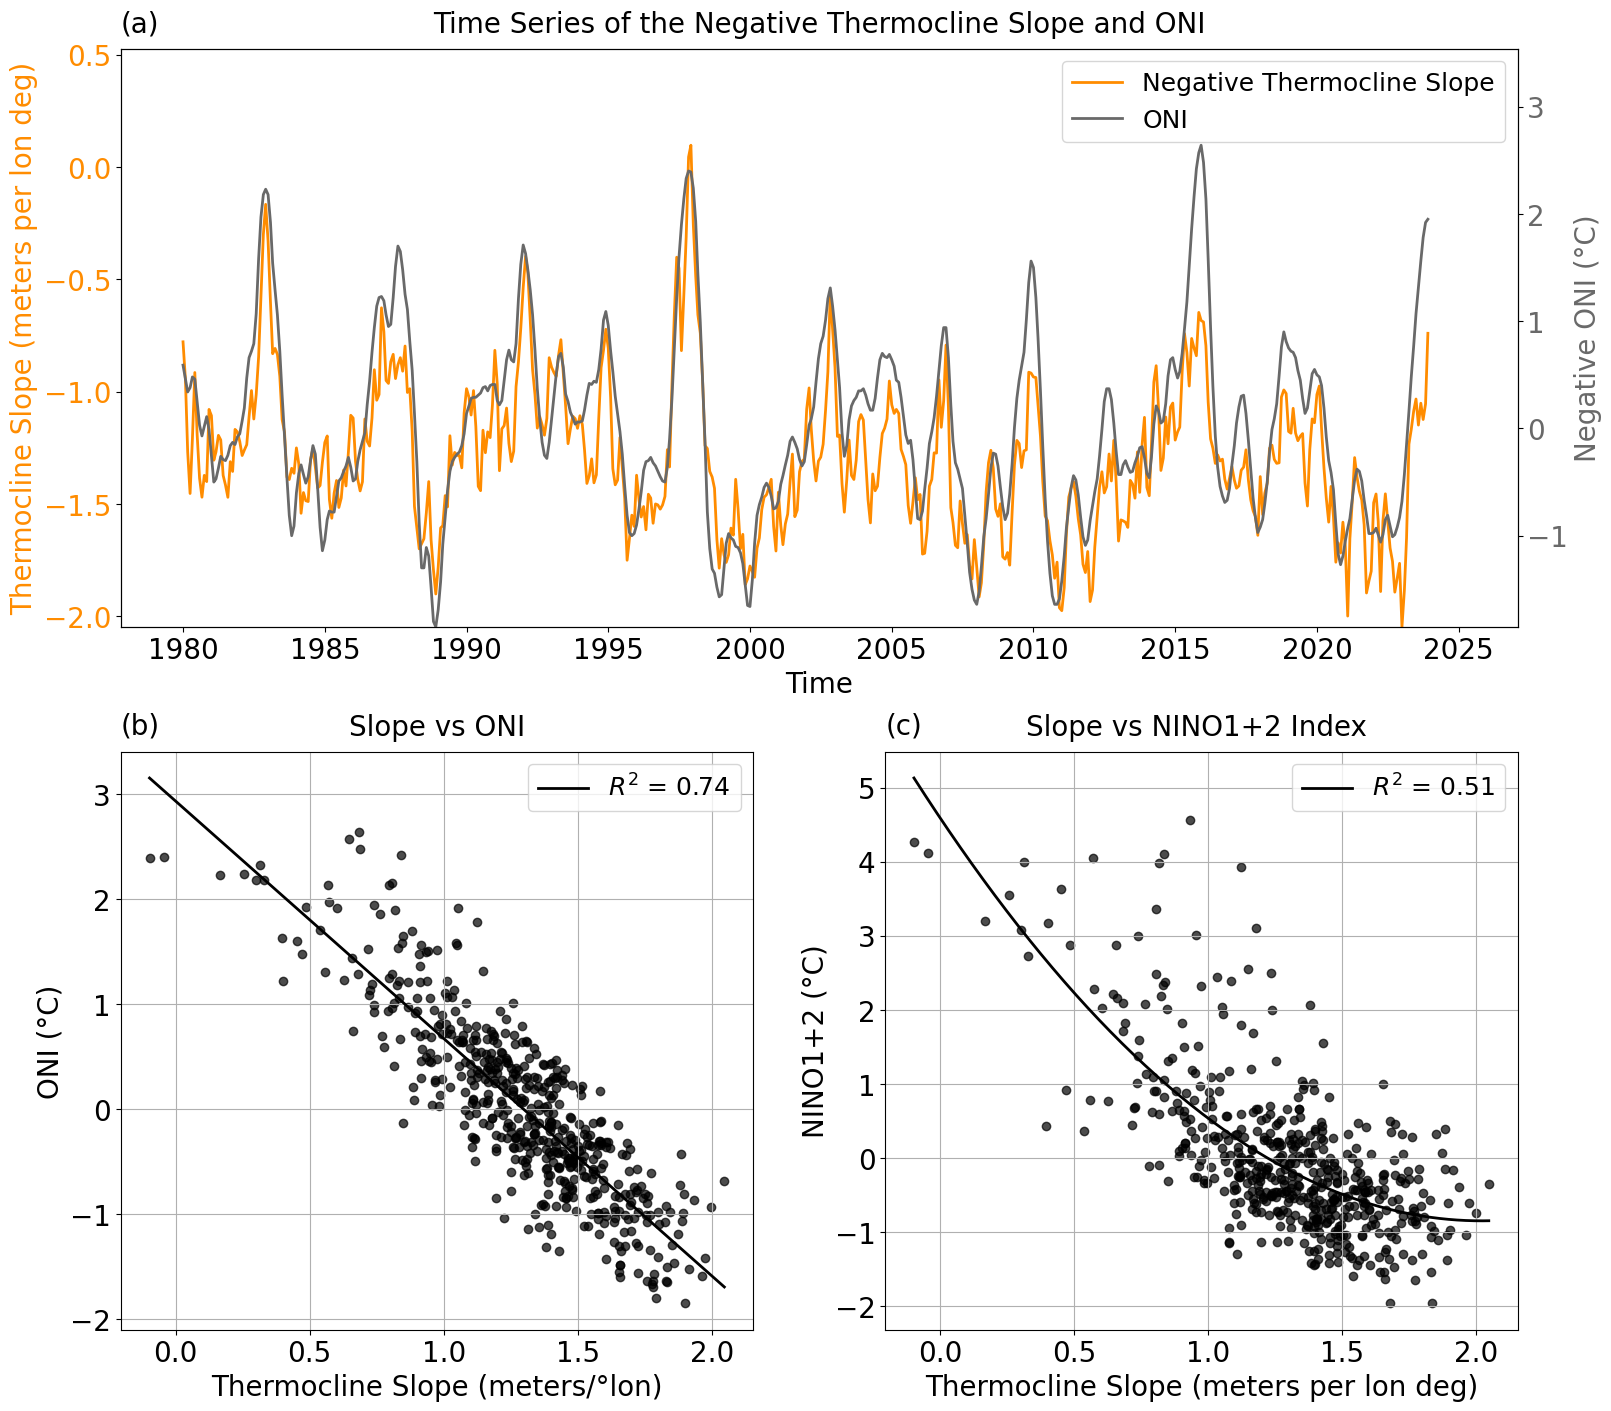

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs  = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :]) 
ax2 = fig.add_subplot(gs[1, 0])  
ax3 = fig.add_subplot(gs[1, 1])  

line1, = ax1.plot(
    merged_all['Date'],
    -merged_all['Slope'],
    color='darkorange', linewidth=2,
    label='Negative Thermocline Slope'
)
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Thermocline Slope (meters per lon deg)', color='darkorange', fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelcolor='darkorange', labelsize=20)

ax1_t = ax1.twinx()
line2, = ax1_t.plot(
    merged_all['Date'],
    merged_all['value'],
    color='dimgray', linewidth=2,
    label='ONI'
)
ax1_t.set_ylabel('Negative ONI (°C)', color='dimgray', fontsize=20)
ax1_t.tick_params(axis='y', labelcolor='dimgray', labelsize=20)

x0, x1 = ax1.get_xlim()
ax1.set_xlim(x0, x1 + (x1-x0)*0.02)
y1 = (-merged_all['Slope']).to_numpy()
ymin1, ymax1 = np.nanmin(y1), np.nanmax(y1)
ax1.set_ylim(ymin1, ymax1 + 0.20*(ymax1 - ymin1))

y2 = merged_all['value'].to_numpy()
ymin2, ymax2 = np.nanmin(y2), np.nanmax(y2)
ax1_t.set_ylim(ymin2, ymax2 + 0.20*(ymax2 - ymin2))
ax1.text(0, 1.02, '(a)', transform=ax1.transAxes,
         fontsize=20, va='bottom', ha='left')
ax1.set_title(
    'Time Series of the Negative Thermocline Slope and ONI',
    fontsize=20, pad=12
)
ax1.legend([line1,line2], ['Negative Thermocline Slope','ONI'],
           loc='upper right', fontsize=18)


s_b, i_b, r_b, *_ = linregress(merged_all['Slope'], merged_all['value'])
r2_b = r_b**2

ax2.scatter(
    merged_all['Slope'], merged_all['value'],
    color='black', alpha=0.7
)
xx = np.array([merged_all['Slope'].min(), merged_all['Slope'].max()])
yy = s_b*xx + i_b
ax2.plot(xx, yy, color='black', linewidth=2,
         label=rf'$R^2$ = {r2_b:.2f}')

ax2.text(0, 1.02, '(b)', transform=ax2.transAxes,
         fontsize=20, va='bottom', ha='left')
ax2.set_title('Slope vs ONI', fontsize=20, pad=12)
ax2.set_xlabel('Thermocline Slope (meters/°lon)', fontsize=20)
ax2.set_ylabel('ONI (°C)', fontsize=20)
ax2.tick_params(labelsize=20)
ax2.grid(True)
ax2.legend(fontsize=18, loc='upper right')

x = merged_nino12['Slope'].values
y = merged_nino12['NINO12'].values

deg = 2

p_coeff = np.polyfit(x, y, deg)           
poly = np.poly1d(p_coeff)

xx = np.linspace(x.min(), x.max(), 200)
yy = poly(xx)

y_pred = poly(x)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r2_poly = 1 - ss_res / ss_tot

ax3.scatter(
    x, y,
    color='black', alpha=0.7
)
ax3.plot(
    xx, yy,
    color='black', linewidth=2,
    label=rf'$R^2$ = {r2_poly:.2f}'
)

ax3.text(0, 1.02, '(c)', transform=ax3.transAxes,
         fontsize=20, va='bottom', ha='left')
ax3.set_title('Slope vs NINO1+2 Index ', fontsize=20, pad=12)
ax3.set_xlabel('Thermocline Slope (meters per lon deg)', fontsize=20)
ax3.set_ylabel('NINO1+2 (°C)', fontsize=20)
ax3.tick_params(labelsize=20)
ax3.grid(True)
ax3.legend(fontsize=18, loc='upper right')
plt.savefig('thermoclinefigures/Figure7.png', 
            dpi=300,             
            bbox_inches='tight')  
plt.show()

# Figure 8

C:\Users\maxhi\AppData\Local\Temp\ipykernel_27444\884895405.py:203: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


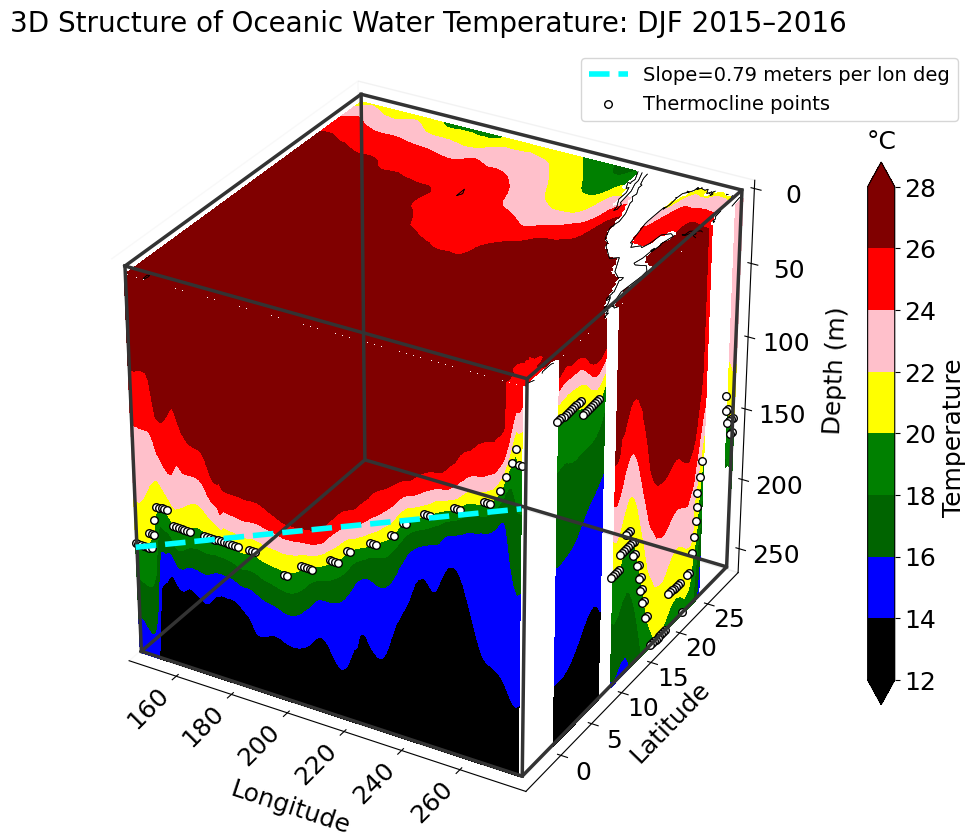

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.basemap import Basemap
from scipy.stats import linregress

cmap_palette = ['black','blue','darkgreen','green','white','yellow','pink','red','maroon']
cmap   = ListedColormap(cmap_palette)
levels = np.arange(12, 30, 2)

paths = ['pottmp/pottmp_2015_C.nc', 'pottmp/pottmp_2016_C.nc']
ds    = xr.open_mfdataset(paths, combine='by_coords')  

ds_sel = ds.sel(
    level = slice(0, 300),
    lat   = slice(-5.0, 30.0),
    lon   = slice(145.0, 280.0)
)

time = ds_sel['time']
djf_mask = ((time.dt.year == 2015) & (time.dt.month == 12)) | \
           ((time.dt.year == 2016) & (time.dt.month.isin([1, 2])))

temp = ds_sel['pottmp'].where(djf_mask, drop=True).mean(dim='time')

depths = ds_sel['level'].values
lats   = ds_sel['lat'].values
lons   = ds_sel['lon'].values

X, Y, Z = np.meshgrid(lons, lats, -depths)

iz   = 0  
ilat = np.abs(lats - (-4.167)).argmin() 
ilon = np.abs(lons - 280.0).argmin()

surface   = temp.isel(level=iz    ).values 
lat_depth = temp.isel(lat  =ilat ).values    
lon_depth = temp.isel(lon  =ilon ).values

fig = plt.figure(figsize=(14, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.grid(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

vmin, vmax = float(temp.min()), float(temp.max())

cs = ax.contourf(
    X[:,:,0], Y[:,:,0], surface,
    zdir='z',
    offset=-depths[iz],
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

m = Basemap(projection='cyl',
            llcrnrlon=lons.min(), urcrnrlon=lons.max(),
            llcrnrlat=lats.min(), urcrnrlat=lats.max())
coast = m.drawcoastlines(linewidth=0.5)
ax.add_collection3d(coast, zs=-depths[iz], zdir='z')

ax.contourf(
    X[0,:,:],      
    lat_depth.T,   
    Z[0,:,:],      
    zdir='y',
    offset=-5,      
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

target_temp = 20.0
tol         = 0.5
pairs = []
for j, lonval in enumerate(lons):
    prof = lat_depth[:, j]
    mask = (prof >= target_temp - tol) & (prof <= target_temp + tol)
    for d in depths[mask]:
        pairs.append((lonval, d))

if pairs:
    arr = np.array(pairs)
    xs, ys = arr[:,0], arr[:,1]
    slope, intercept, *_ = linregress(xs, ys)
    order = np.argsort(xs)
    fit_z = slope * xs[order] + intercept

    ax.plot(
        xs[order], -fit_z,     
        zs=-5, zdir='y',
        color='cyan', lw=4, ls='--',
        label=f"Slope={-slope:.2f} meters per lon deg",
        zorder=200
    )
    ax.scatter(
        xs, -ys,
        zs=-5, zdir='y',
        color='white', edgecolor='black',
        s=30, depthshade=False,
        label="Thermocline points",
        zorder=201
    )
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=14)

ax.contourf(
    lon_depth.T,    
    Y[:,-1,:],      
    Z[:,-1,:],   
    zdir='x',
    offset=280,    
    levels=levels,
    cmap=cmap,
    alpha=1,
    extend='both'
)

lat_hits, depth_hits = [], []
for j, latv in enumerate(lats):
    prof = lon_depth[:, j]
    mask = (prof >= target_temp - tol) & (prof <= target_temp + tol)
    for d in depths[mask]:
        lat_hits.append(latv)
        depth_hits.append(d)

if lat_hits:
    xs = np.array(lat_hits)    
    zs = -np.array(depth_hits)   
    ax.scatter(
        np.full_like(xs, lons[ilon]),
        xs, zs,
        color='white', edgecolor='black',
        s=30, depthshade=False,
        label="20 °C points (lon=280°E)",
        zorder=200
    )

xmin, xmax = lons.min(), lons.max()
ymin, ymax = lats.min(), lats.max()
zmin, zmax = -depths.max(), 0

edges_kw = dict(color='0.2', linewidth=2.5, zorder=100)

ax.plot([xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        [zmin]*5, **edges_kw)

ax.plot([xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        [zmax]*5, **edges_kw)

for x in (xmin, xmax):
    for y in (ymin, ymax):
        ax.plot([x, x], [y, y], [zmin, zmax], **edges_kw)

lon_ticks   = np.arange(160, 281, 20)
lat_ticks   = np.arange(-5, 31, 5)
depth_ticks = np.arange(0, depths.max()+1, 50).astype('int64')

ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_zticks(-depth_ticks)

ax.set_xticklabels([f"{t:.0f}" for t in lon_ticks], rotation=45, ha='right')
ax.set_yticklabels([f"{t:.0f}" for t in lat_ticks], va='bottom', fontsize=12)
ax.set_zticklabels(depth_ticks)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='z', pad=10, labelsize=18)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=8)

ax.set_xlabel('Longitude', fontsize=18, labelpad=18)
ax.set_ylabel('Latitude',  fontsize=18)
ax.set_zlabel('Depth (m)', fontsize=18, labelpad=22)

ax.set_xlim(lons.min(), lons.max())
ax.set_ylim(lats.min(), lats.max())
ax.set_zlim(-depths.max(), 0)

ax.set_box_aspect((1, 1, 1))
ax.view_init(elev=30, azim=-60)

cbar = fig.colorbar(
    cs, ax=ax, ticks=levels, extend='both',
    fraction=0.025, pad=0.05
)
cbar.set_label('Temperature ', fontsize=18)
cbar.ax.set_title('°C', fontsize=18, pad=10)
cbar.ax.tick_params(labelsize=18)

ax.set_title(
    "3D Structure of Oceanic Water Temperature: DJF 2015–2016",
    fontsize=20, pad=12
)

plt.tight_layout()
plt.savefig('thermoclinefigures/Figure8_DJF_2015_2016.png',
            dpi=300, bbox_inches='tight')
plt.show()
